# Подготовка к обработке данных

## Подключение и преднастройка необходимых компонент

Подключение Google Drive

In [1]:
%%time
# монтируем диск
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
CPU times: user 1.67 s, sys: 320 ms, total: 1.99 s
Wall time: 23.1 s


Подключение глобально необходимых библиотек

In [2]:
# для отрисовки графиков

import os
import random as rand

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import polars as pl

# для объединения в одну модель
from sklearn.pipeline import Pipeline

# для масштабирования
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# модули оценщика
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split

# для вывода результатов
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, r2_score
from sklearn.metrics import mean_absolute_error, mean_squared_error

Инициализация константы для random_state

In [3]:
# для повторяемости результатов
SEED = 100

Настройка графиков

In [4]:
# преднастройка графиков
plt.style.use("fivethirtyeight")
sns.set_style('whitegrid')

# чтобы графики были в одном окне
%matplotlib inline

Установка catboost

In [5]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 5.3 MB/s eta 0:00:00


## Загрузка датасета

Чтение датасета, чтобы к нему можно было обратиться методами sklearn

In [6]:
# загружаем данные с Google Drive
df = pd.read_csv('/content/drive/MyDrive/Шестой Семестр/Динамические языки/spotify_songs.csv')

In [ ]:
#df.drop('Unnamed: 0', axis=1, inplace=True)

Проверка типов данных столбцов и того, как их интерпретировал pandas

In [7]:
# выводим информацию о датасете
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32833 entries, 0 to 32832
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   track_id                  32833 non-null  object 
 1   track_name                32828 non-null  object 
 2   track_artist              32828 non-null  object 
 3   track_popularity          32833 non-null  int64  
 4   track_album_id            32833 non-null  object 
 5   track_album_name          32828 non-null  object 
 6   track_album_release_date  32833 non-null  object 
 7   playlist_name             32833 non-null  object 
 8   playlist_id               32833 non-null  object 
 9   playlist_genre            32833 non-null  object 
 10  playlist_subgenre         32833 non-null  object 
 11  danceability              32833 non-null  float64
 12  energy                    32833 non-null  float64
 13  key                       32833 non-null  int64  
 14  loudne

## Анализ датасета

### Проверка статистики

Проверка на наличие отклонений важных характеристик числовых признаков: среднего арифметического, стандартного квадратичного отклонения, перцентилей, а также максимума и минимума

In [8]:
# выводим статистику числовых записей датасета
df.describe()

,track_popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
count,32833.000000,32833.000000,32833.000000,32833.000000,32833.000000,32833.000000,32833.000000,32833.000000,32833.000000,32833.000000,32833.000000,32833.000000,32833.000000
mean,42.477081,0.654850,0.698619,5.374471,-6.719499,0.565711,0.107068,0.175334,0.084747,0.190176,0.510561,120.881132,225799.811622
std,24.984074,0.145085,0.180910,3.611657,2.988436,0.495671,0.101314,0.219633,0.224230,0.154317,0.233146,26.903624,59834.006182
min,0.000000,0.000000,0.000175,0.000000,-46.448000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4000.000000
25%,24.000000,0.563000,0.581000,2.000000,-8.171000,0.000000,0.041000,0.015100,0.000000,0.092700,0.331000,99.960000,187819.000000
50%,45.000000,0.672000,0.721000,6.000000,-6.166000,1.000000,0.062500,0.080400,0.000016,0.127000,0.512000,121.984000,216000.000000
75%,62.000000,0.761000,0.840000,9.000000,-4.645000,1.000000,0.132000,0.255000,0.004830,0.248000,0.693000,133.918000,253585.000000
max,100.000000,0.983000,1.000000,11.000000,1.275000,1.000000,0.918000,0.994000,0.994000,0.996000,0.991000,239.440000,517810.000000


Уточнение показателей для категориальных данных

In [9]:
# выводим статистику категориальных записей датасета
df.describe(include = [object, 'bool'])

,track_id,track_name,track_artist,track_album_id,track_album_name,track_album_release_date,playlist_name,playlist_id,playlist_genre,playlist_subgenre
count,32833,32828,32828,32833,32828,32833,32833,32833,32833,32833
unique,28356,23449,10692,22545,19743,4530,449,471,6,24
top,7BKLCZ1jbUBVqRi2FVlTVw,Poison,Martin Garrix,5L1xcowSxwzFUSJzvyMp48,Greatest Hits,2020-01-10,Indie Poptimism,4JkkvMpVl4lSioqQjeAL0q,edm,progressive electro house
freq,10,22,161,42,139,270,308,247,6043,1809


In [12]:
df["playlist_genre"].value_counts()

playlist_genre
edm      6043
rap      5746
pop      5507
r&b      5431
latin    5155
rock     4951
Name: count, dtype: int64

In [13]:
df["playlist_subgenre"].value_counts()

playlist_subgenre
progressive electro house    1809
southern hip hop             1675
indie poptimism              1672
latin hip hop                1656
neo soul                     1637
pop edm                      1517
electro house                1511
hard rock                    1485
gangster rap                 1458
electropop                   1408
urban contemporary           1405
hip hop                      1322
dance pop                    1298
classic rock                 1296
trap                         1291
tropical                     1288
latin pop                    1262
hip pop                      1256
big room                     1206
new jack swing               1133
post-teen pop                1129
permanent wave               1105
album rock                   1065
reggaeton                     949
Name: count, dtype: int64

Оценка категориальных признаков на наличие артефактов

In [14]:
# итерируемся по столбцам датасета
for name, values in df.items():
  if values.dtype != np.float64:
    print(f"{name}: {df[name].unique()}")

track_id: ['6f807x0ima9a1j3VPbc7VN' '0r7CVbZTWZgbTCYdfa2P31'
 '1z1Hg7Vb0AhHDiEmnDE79l' ... '7ImMqPP3Q1yfUHvsdn7wEo'
 '2m69mhnfQ1Oq6lGtXuYhgX' '29zWqhca3zt5NsckZqDf6c']
track_name: ["I Don't Care (with Justin Bieber) - Loud Luxury Remix"
 'Memories - Dillon Francis Remix' 'All the Time - Don Diablo Remix' ...
 'Sweet Surrender - Radio Edit' 'Only For You - Maor Levi Remix'
 'Typhoon - Original Mix']
track_artist: ['Ed Sheeran' 'Maroon 5' 'Zara Larsson' ...
 'Ferry Corsten feat. Jenny Wahlstrom' 'Tegan and Sara' 'Mat Zo']
track_popularity: [ 66  67  70  60  69  62  68  58  63  65  35  64   8  30  56  55  59  87
  83  61  57  53  34  74  46  52  45  51  48  39  71  81  85  76  75  73
  79  16  84  37  36  72  77  82  41   5  24  18  47  80  96  86  19  27
  43  91  42  21  54   9  23  40   2  11  50  10  49   6  25  95   1   4
  28  29  38  17  31  26  32  12  44   7   0  13  78  88  94  22  98  97
  90  93  92   3  33  20  14  15  89 100  99]
track_album_id: ['2oCs0DGTsRO98Gh5ZSl2Cx' '63

Распредение жанров

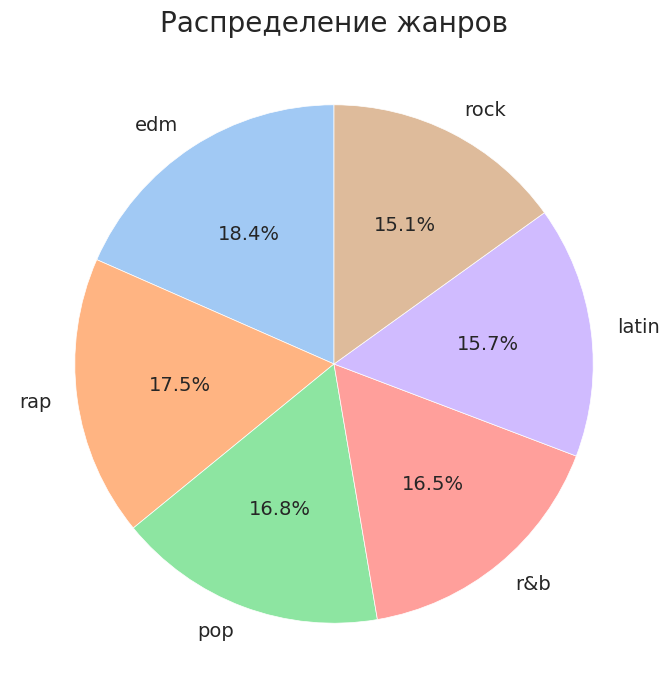

In [15]:
genre_counts = df['playlist_genre'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(genre_counts, labels=genre_counts.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('pastel'))
plt.title('Распределение жанров')
plt.show()

Проверка статистики по ряду признаков песни

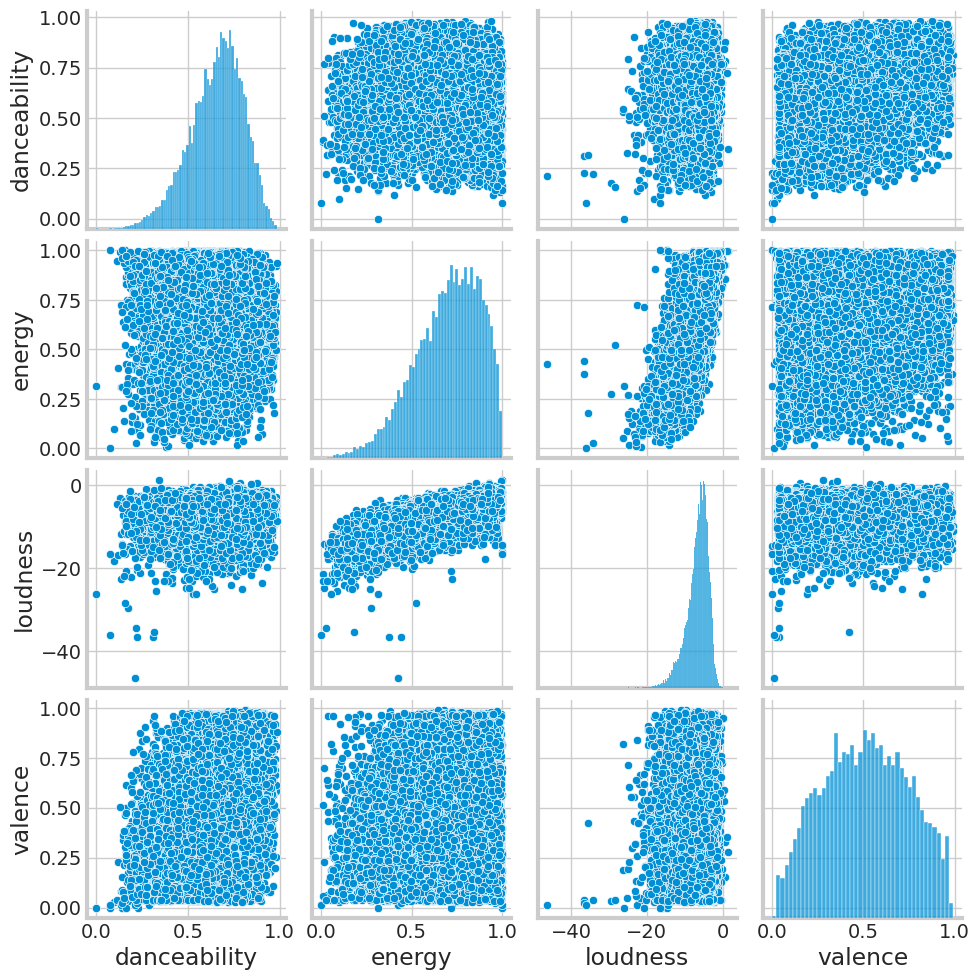

In [16]:
sns.pairplot(df[['danceability', 'energy', 'loudness', 'valence']])
plt.show()

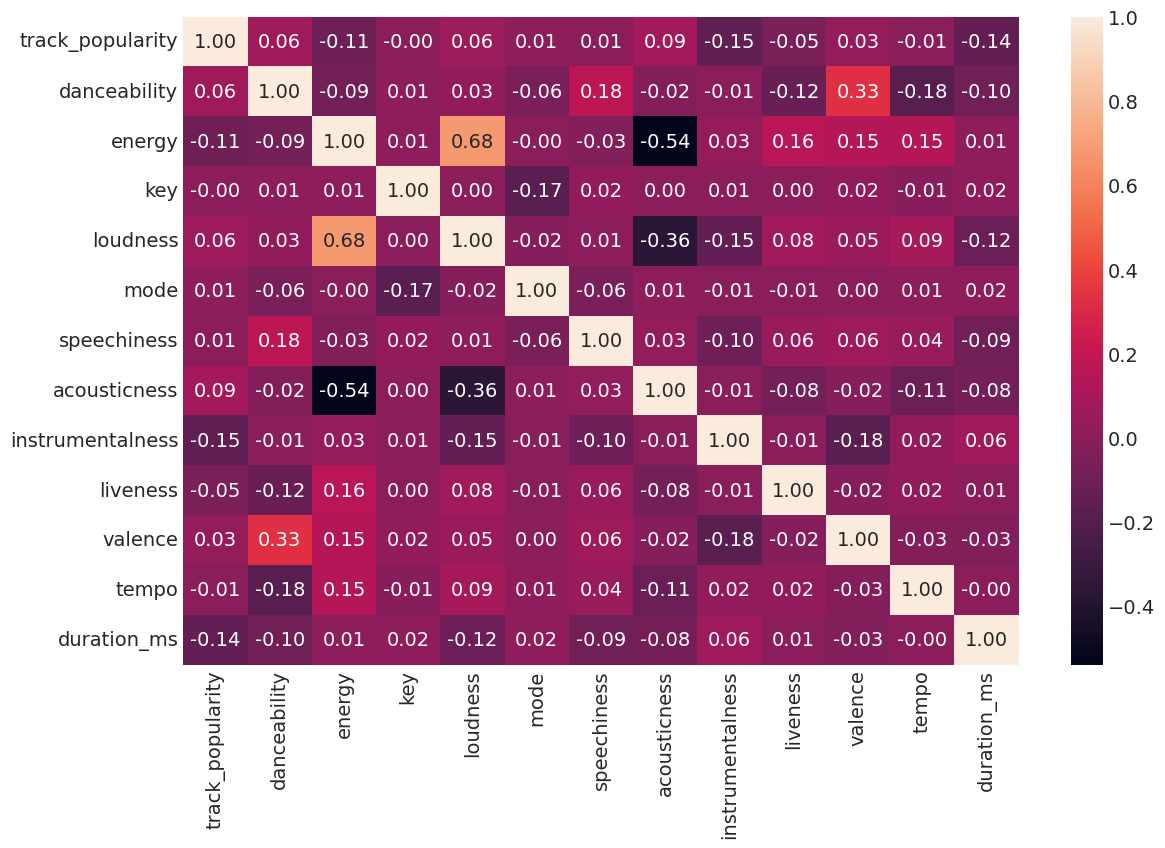

In [17]:
numeric_columns = df.select_dtypes(include=['float64', 'int64'])

correlation_matrix = numeric_columns.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f")
plt.show()

На основании приведенных графиков можно сделать вывод о сбалансированности датасета

### Обобщение датасета

In [18]:
len(df)

32833

Создание обобщенного датасета

In [33]:
# новый датасет для проверки корелляции
grouped_df = df

# удаляем старые столбцы
grouped_df = grouped_df.drop([col for col in df.columns if col.startswith((
    'track_name', 'track_artist', 'track_album_name', 'playlist_name', 'track_id', 'track_album_id', 'playlist_id', 'track_album_release_date'))], axis=1)

#grouped_df = grouped_df.drop([col for col in df.columns if col.startswith((
#    'key', 'type', 'id', 'uri', 'track_href', 'analysis_url', 'song_name', 'title'))], axis=1)
# выводим получившуюся структуру
grouped_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32833 entries, 0 to 32832
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   track_popularity   32833 non-null  int64  
 1   playlist_genre     32833 non-null  object 
 2   playlist_subgenre  32833 non-null  object 
 3   danceability       32833 non-null  float64
 4   energy             32833 non-null  float64
 5   key                32833 non-null  int64  
 6   loudness           32833 non-null  float64
 7   mode               32833 non-null  int64  
 8   speechiness        32833 non-null  float64
 9   acousticness       32833 non-null  float64
 10  instrumentalness   32833 non-null  float64
 11  liveness           32833 non-null  float64
 12  valence            32833 non-null  float64
 13  tempo              32833 non-null  float64
 14  duration_ms        32833 non-null  int64  
dtypes: float64(9), int64(4), object(2)
memory usage: 3.8+ MB


In [34]:
# на всякий случай проверяем случайную запись
print(grouped_df.iloc[10])

track_popularity            58
playlist_genre             pop
playlist_subgenre    dance pop
danceability             0.679
energy                   0.923
key                          6
loudness                  -6.5
mode                         1
speechiness              0.181
acousticness             0.146
instrumentalness      0.000005
liveness                 0.124
valence                  0.752
tempo                  121.984
duration_ms             207894
Name: 10, dtype: object


Прямое преобразование категориальных признаков в числовые

In [35]:
grouped_df = pd.get_dummies(grouped_df, columns=['playlist_genre', 'playlist_subgenre'], drop_first = True)
grouped_df

,track_popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,...,playlist_subgenre_new jack swing,playlist_subgenre_permanent wave,playlist_subgenre_pop edm,playlist_subgenre_post-teen pop,playlist_subgenre_progressive electro house,playlist_subgenre_reggaeton,playlist_subgenre_southern hip hop,playlist_subgenre_trap,playlist_subgenre_tropical,playlist_subgenre_urban contemporary
0,66,0.748,0.916,6,-2.634,1,0.0583,0.102000,0.000000,0.0653,...,False,False,False,False,False,False,False,False,False,False
1,67,0.726,0.815,11,-4.969,1,0.0373,0.072400,0.004210,0.3570,...,False,False,False,False,False,False,False,False,False,False
2,70,0.675,0.931,1,-3.432,0,0.0742,0.079400,0.000023,0.1100,...,False,False,False,False,False,False,False,False,False,False
3,60,0.718,0.930,7,-3.778,1,0.1020,0.028700,0.000009,0.2040,...,False,False,False,False,False,False,False,False,False,False
4,69,0.650,0.833,1,-4.672,1,0.0359,0.080300,0.000000,0.0833,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32828,42,0.428,0.922,2,-1.814,1,0.0936,0.076600,0.000000,0.0668,...,False,False,False,False,True,False,False,False,False,False
32829,20,0.522,0.786,0,-4.462,1,0.0420,0.001710,0.004270,0.3750,...,False,False,False,False,True,False,False,False,False,False
32830,14,0.529,0.821,6,-4.899,0,0.0481,0.108000,0.000001,0.1500,...,False,False,False,False,True,False,False,False,False,False
32831,15,0.626,0.888,2,-3.361,1,0.1090,0.007920,0.127000,0.3430,...,False,False,False,False,True,False,False,False,False,False


##Старый способ перевода категориальных признаков в числовые

In [ ]:
# переведем категориальный признак «genre» в числовой
genre_new = {
    'Underground Rap':0,
    'Dark Trap':1,
    'Hiphop':,
    'trance' :,
    'trap':,
    'techhouse':,
    'dnb':,
    'psytrance':,
    'techno':,
    'hardstyle':,
    'RnB':,
    'Trap Metal':,
    'Rap':,
    'Emo':,
    'Pop':,
}

grouped_df['playlist_genre'] = grouped_df['playlist_genre'].map(genre_new).astype('uint8')

In [ ]:
# переведем категориальный признак «subgenre» в числовой
subgenre_new = {
    'dance pop': 1,
    'post-teen pop': 2,
    'electropop': 3,
    'indie poptimism': 4,
    'hip hop':5,
    'southern hip hop': 6,
    'gangster rap': 7,
    'trap': 8,
    'album rock': 9,
    'classic rock': 10,
    'permanent wave': 11,
    'hard rock': 12,
    'tropical': 13,
    'latin pop': 14,
    'reggaeton':15,
    'latin hip hop': 16,
    'urban contemporary': 17,
    'hip pop': 18,
    'new jack swing': 19,
    'neo soul': 20,
    'electro house': 21,
    'big room': 22,
    'pop edm':23,
    'progressive electro house':24,
}

grouped_df['playlist_subgenre'] = grouped_df['playlist_subgenre'].map(subgenre_new).astype('uint8')
grouped_df['playlist_subgenre'].unique()

##Проверки



Вывод случайной записи

In [22]:
# на всякий случай проверяем случайную запись
sample_index = rand.randint(0, len(grouped_df['mode']) - 1)
print(grouped_df.iloc[sample_index])

danceability                                     0.767
energy                                           0.787
key                                                  2
loudness                                         -8.28
mode                                                 1
speechiness                                     0.0566
acousticness                                    0.0678
instrumentalness                               0.00509
liveness                                          0.43
valence                                          0.839
tempo                                          121.102
duration_ms                                     347347
playlist_genre_latin                             False
playlist_genre_pop                                True
playlist_genre_r&b                               False
playlist_genre_rap                               False
playlist_genre_rock                              False
playlist_subgenre_big room                       False
playlist_s

## Подготовка данных

### Заполнение отсутствующих значений

Проверка на наличие пропусков

In [23]:
# отдельно считаем количество пустых записей в столбцах
skips_num = grouped_df.isna().sum()

print(f"Пропуски по столбцам:\n{skips_num}\n")

# выводим сумму по столбцам
print(f"Всего пропусков: {skips_num.sum()}")

Пропуски по столбцам:
danceability                                   0
energy                                         0
key                                            0
loudness                                       0
mode                                           0
speechiness                                    0
acousticness                                   0
instrumentalness                               0
liveness                                       0
valence                                        0
tempo                                          0
duration_ms                                    0
playlist_genre_latin                           0
playlist_genre_pop                             0
playlist_genre_r&b                             0
playlist_genre_rap                             0
playlist_genre_rock                            0
playlist_subgenre_big room                     0
playlist_subgenre_classic rock                 0
playlist_subgenre_dance pop                    

In [36]:
grouped_df = grouped_df.sample(n=10000)

### Выбор обучающего и тестового наборов

In [37]:
average_popularity = grouped_df['track_popularity'].mean()
grouped_df['track_popular'] = grouped_df['track_popularity'].apply(lambda x: 1 if x > average_popularity else 0)
grouped_df = grouped_df.drop(columns=['track_popularity'])

In [38]:
grouped_df = grouped_df.drop(columns=['track_popularity'])

Разделение данных на те, по которым предсказываем, и на те, которые предсказываем

In [39]:
# выбираем целевой признак
y_df = grouped_df['track_popular']

# выбираем остальные признаки
X_df = grouped_df.drop(['track_popular'], axis=1)

# выводим на всякий случай
y_df

15720    1
23687    1
6611     1
28031    0
28912    0
        ..
30191    1
25668    0
408      0
8316     1
27380    0
Name: track_popular, Length: 10000, dtype: int64

Выделяем обучающую и тестовую выборки

In [40]:
# разделяем выборку
X_train, X_test, y_train, y_test = train_test_split(
    X_df, y_df, test_size = 0.2)

### Масштабирование признаков

Выбираем тип масштабирования

In [41]:
# выбираем тип scaler'а
scaler = StandardScaler()

# скалируем
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# проверяем
X_train

array([[ 1.16119772,  0.21131497, -1.23081282, ..., -0.19874868,
        -0.19670091, -0.21707238],
       [ 0.85393748,  0.21683132, -0.95245859, ..., -0.19874868,
        -0.19670091, -0.21707238],
       [-0.87090977,  0.29406025,  0.99602103, ..., -0.19874868,
        -0.19670091, -0.21707238],
       ...,
       [ 0.19053469, -0.04243721,  0.7176668 , ..., -0.19874868,
        -0.19670091, -0.21707238],
       [-0.4170026 ,  0.85672812,  0.43931257, ..., -0.19874868,
        -0.19670091, -0.21707238],
       [ 0.47684537,  0.85121177,  1.55272949, ..., -0.19874868,
        -0.19670091, -0.21707238]])

# **ЛР1**

## Описание

Задание 1. Найти набор данных (датасет) для классификации удовлетворяющий следующим условиям: более 10 000 строк, более 20 столбцов, разные типы в столбцах, обязательно наличие целевого признака (таргета).
<br>
Задание 2 . Провести классификацию найденного датасета, методом к- ближайших соседей. В формате *Markdown* писать пояснения. Объяснить почему были выбраны именно такие гиперпараметры, была ли перекрестная проверка, и т.д.
<br><br>
P.S. Все решения выполнять в формате *Jupyter Notebook* и выкладывать на свои гитхабы.


## Решение

### Выбор датасета

На основании приведенных в описании 1 лаборатоной работы критериев, был выбран датасет по песням платформы Spotify. Целью работы является выявление популярен ли трек на основании заранее заданных параметров. Целевой показатель при этом может принимать 2 значения: 1 (популярен) или 0 (непопулярен). Ссылка на используемый датасет приведена далее: https://www.kaggle.com/datasets/joebeachcapital/30000-spotify-songs

### Подключение модулей

In [42]:
# стандартный модуль KNN
from sklearn.neighbors import KNeighborsClassifier

### **sklearn.neighbors.KNeighborsClassifier**

---



#### С кросс-валидацией

Проведение процедуры кросс-валидации

In [47]:
%%time
# Сокращение диапазонов параметров
k_range = list(range(1, 21))  # Изменено на диапазон от 1 до 20

# Алгоритмы для поиска ближайших соседей
algorithms = ['auto', 'ball_tree', 'kd_tree', 'brute']

# Метрики расстояния
metrics = ['euclidean', 'manhattan', 'chebyshev']

parameters = {
    'n_neighbors': k_range,
    'algorithm': algorithms,
    'weights': ['uniform', 'distance'],
    'leaf_size': [10, 20, 30],
    'metric': metrics,
}

# Используем RandomizedSearchCV вместо GridSearchCV
grid_knn = RandomizedSearchCV(
    KNeighborsClassifier(),
    parameters,
    scoring='f1',
    n_jobs=-1,  # использовать все доступные процессоры
)

# обучаем модель
grid_knn.fit(X_train, y_train)

CPU times: user 349 ms, sys: 56.2 ms, total: 405 ms
Wall time: 30.6 s


RandomizedSearchCV(estimator=KNeighborsClassifier(), n_jobs=-1,
                   param_distributions={'algorithm': ['auto', 'ball_tree',
                                                      'kd_tree', 'brute'],
                                        'leaf_size': [10, 20, 30],
                                        'metric': ['euclidean', 'manhattan',
                                                   'chebyshev'],
                                        'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8,
                                                        9, 10, 11, 12, 13, 14,
                                                        15, 16, 17, 18, 19,
                                                        20],
                                        'weights': ['uniform', 'distance']},
                   scoring='f1')

Вывод результата кросс-валидации

In [48]:
# результаты кросс-валидации
print(f'Лучшие параметры:\n{grid_knn.best_params_}\n')
print("Показатель f1 для лучшей модели составил: {:.2f}%".
      format(grid_knn.best_score_ * 100) + '\n')

# предсказываем результат на тестовой выборке
grid_knn_pred = grid_knn.predict(X_test)

# оцениваем модель
print(f'Сравнение метрик: \n{classification_report(y_test, grid_knn_pred)}\n')
print(f'Матрица ошибок: \n{confusion_matrix(y_test, grid_knn_pred)}\n')

Лучшие параметры:
{'weights': 'distance', 'n_neighbors': 19, 'metric': 'euclidean', 'leaf_size': 10, 'algorithm': 'ball_tree'}

Показатель f1 для лучшей модели составил: 69.81%

Сравнение метрик: 
              precision    recall  f1-score   support

           0       0.63      0.52      0.57       910
           1       0.65      0.74      0.69      1090

    accuracy                           0.64      2000
   macro avg       0.64      0.63      0.63      2000
weighted avg       0.64      0.64      0.64      2000


Матрица ошибок: 
[[477 433]
 [280 810]]



# **ЛР2**

## Описание

Задание 1 . Провести классификацию найденного датасета, методом машины опорных векторов. В формате *Markdown* писать пояснения. Объяснить почему были выбраны именно такие гиперпараметры, была ли перекрестная проверка, и т.д.
<br><br>
P.S. Все решения выполнять в формате *Jupyter Notebook* и выкладывать на свои гитхабы.

## Решение

### Подключение модулей

Метод машины опорных векторов

In [49]:
# общий модуль для бинарной и многоклассовой классификации
from sklearn.svm import SVC

# специализированный модуль для классификации с линейным ядром
from sklearn.svm import LinearSVC

### **sklearn.svm.SVC**

---

#### С кросс-валидацией

Проведение процедуры кросс-валидации

In [50]:
%%time

# задаем гиперпараметры
parameters = {
    'C': [0.1, 1], # коэффициент регуляризации
    'kernel': ['poly'], # тип ядра
    'degree': [3, 4], # степень для 'poly' ядра
    'gamma': ['scale', 'auto'], # коэффициент ядра для 'rbf', 'poly' и 'sigmoid'
    'coef0': [0.0, 0.5, 1.0], # смещение для 'poly' и 'sigmoid'
    'tol': [1e-3, 1e-4], # пороговое значение для оптимизации
    'class_weight': [None, 'balanced'], # веса классов
}

# подбираем лучшие параметры
grid_svm_svc = RandomizedSearchCV(
    SVC(),
    parameters,
    scoring='f1',
    n_jobs = -1
)

# обучаем модель
grid_svm_svc.fit(X_train, y_train)

CPU times: user 5.48 s, sys: 500 ms, total: 5.98 s
Wall time: 2min 52s


RandomizedSearchCV(estimator=SVC(), n_jobs=-1,
                   param_distributions={'C': [0.1, 1],
                                        'class_weight': [None, 'balanced'],
                                        'coef0': [0.0, 0.5, 1.0],
                                        'degree': [3, 4],
                                        'gamma': ['scale', 'auto'],
                                        'kernel': ['poly'],
                                        'tol': [0.001, 0.0001]},
                   scoring='f1')

Вывод результата кросс-валидации

In [52]:
# результаты кросс-валидации
print(f'Лучшие параметры:\n{grid_svm_svc.best_params_}\n')
print("Показатель f1 для лучшей модели составил: {:.2f}%".
      format(grid_svm_svc.best_score_ * 100) + '\n')

# предсказываем результат на тестовой выборке
grid_svm_svc_pred = grid_svm_svc.predict(X_test)

# оцениваем модель
print(f'Сравнение метрик: \n{classification_report(y_test, grid_svm_svc_pred)}\n')
print(f'Матрица ошибок: \n{confusion_matrix(y_test, grid_svm_svc_pred)}\n')

Лучшие параметры:
{'tol': 0.0001, 'kernel': 'poly', 'gamma': 'scale', 'degree': 3, 'coef0': 0.0, 'class_weight': None, 'C': 0.1}

Показатель f1 для лучшей модели составил: 70.38%

Сравнение метрик: 
              precision    recall  f1-score   support

           0       0.65      0.48      0.55       910
           1       0.64      0.78      0.70      1090

    accuracy                           0.64      2000
   macro avg       0.64      0.63      0.63      2000
weighted avg       0.64      0.64      0.63      2000


Матрица ошибок: 
[[435 475]
 [239 851]]



# **ЛР3**

## Описание

Задание 1 . Провести классификацию найденного датасета, методами линеной и логистической регрессий . В формате *Markdown* написать пояснения. Объяснить почему были выбраны именно такие гиперпараметры, была ли перекрестная проверка, и т.д.
<br><br>
P.S. Все решения выполнять в формате *Jupyter Notebook* и выкладывать на свои гитхабы.

## Решение

### Подключение модулей

Методы линейной регрессии

In [55]:
# стандартная модель
from sklearn.linear_model import LinearRegression

# для комбинированных L1- и L2-регуляризаций
from sklearn.linear_model import ElasticNet

# для L1-регуляризации
from sklearn.linear_model import Lasso

# для L2-регуляризации
from sklearn.linear_model import Ridge

# для стохастического градиентного спуска
from sklearn.linear_model import SGDRegressor

Методы логистической регрессии

In [56]:
# стандартная модель, поддерживающая бинарную, One-vs-Rest и мультиномиальную
# логистическую регрессию с опциональной регуляризацией L1, L2 или Elastic-Net
from sklearn.linear_model import LogisticRegression

### **sklearn.linear_model.LinearRegression**

---



### **sklearn.linear_model.LogisticRegression**

---



#### С кросс-валидацией

Проведение процедуры кросс-валидации

In [69]:
%%time

# задаем диапазон параметров
parameters = {
    'penalty': ['l1', 'l2'], # тип регуляризации
    'C': [0.001, 0.01, 0.1, 1, 10], # инверсное значение коэффициента регуляризации
    #'fit_intercept': [True, False], # следует ли добавлять константный член в линейную модель
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], # алгоритм оптимизации
    'tol': [1e-4, 1e-3], # пороговое значение для оптимизации
    'class_weight': [None, 'balanced'] # веса классов
}

# подбираем лучшие параметры
grid_regression_logistic = RandomizedSearchCV(
    LogisticRegression(),
    parameters,
    scoring='f1_weighted',
    n_jobs = -1
)
# обучаем модель
grid_regression_logistic.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
20 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError: Solver

CPU times: user 191 ms, sys: 32 ms, total: 223 ms
Wall time: 3.56 s


RandomizedSearchCV(estimator=LogisticRegression(), n_jobs=-1,
                   param_distributions={'C': [0.001, 0.01, 0.1, 1, 10],
                                        'penalty': ['l1', 'l2'],
                                        'solver': ['newton-cg', 'lbfgs',
                                                   'liblinear', 'sag', 'saga'],
                                        'tol': [0.0001, 0.001]},
                   scoring='f1_weighted')

Вывод результата кросс-валидации

In [62]:
# результаты кросс-валидации
print(f'Лучшие параметры:\n{grid_regression_logistic.best_params_}\n')
print("Показатель f1 для лучшей модели составил: {:.2f}%".
      format(grid_regression_logistic.best_score_ * 100) + '\n')

# предсказываем результат на тестовой выборке
grid_regression_logistic_pred = grid_regression_logistic.predict(X_test)

# оцениваем модель
print(f'Сравнение метрик: \n{classification_report(y_test, grid_regression_logistic_pred)}\n')
print(f'Матрица ошибок: \n{confusion_matrix(y_test, grid_regression_logistic_pred)}\n')

Лучшие параметры:
{'solver': 'liblinear', 'penalty': 'l1', 'C': 0.1}

Показатель f1 для лучшей модели составил: 64.34%

Сравнение метрик: 
              precision    recall  f1-score   support

           0       0.64      0.55      0.59       910
           1       0.66      0.74      0.70      1090

    accuracy                           0.65      2000
   macro avg       0.65      0.65      0.65      2000
weighted avg       0.65      0.65      0.65      2000


Матрица ошибок: 
[[499 411]
 [280 810]]



# **ЛР4**


## Описание

Задание 1 . Провести классификацию найденного датасета, методами наивного Байеса  . В формате *Markdown* написать пояснения. Объяснить почему были выбраны именно такие гиперпараметры, была ли перекрестная проверка, и т.д.
<br><br>
P.S. Все решения выполнять в формате *Jupyter Notebook* и выкладывать на свои гитхабы.

## Решение

### Подключение модулей

In [63]:
# гауссовский наивный байесовский алгоритм для классификации
# когда вероятность появления признаков Гауссова
from sklearn.naive_bayes import GaussianNB

# для классификации текстовых документов, где признаки представляют собой частоты слов
from sklearn.naive_bayes import MultinomialNB

# для работы с бинарными признаками
from sklearn.naive_bayes import ComplementNB

# обобщение наивного байесовского классификатора, учитывающее
# дополнительные сведения о распределении признаков
from sklearn.naive_bayes import BernoulliNB

# для работы с категориальными признаками
from sklearn.naive_bayes import CategoricalNB

### **sklearn.naive_bayes.BernoulliNB**

---



#### С кросс-валидацией

Проведение процедуры кросс-валидации

In [68]:
%%time

# задаем диапазон параметров
parameters = {
    'alpha': [0, 0.001, 0.01, 0.1, 1.0, 10.0], # аддитивное (Лапласа-Лидстоуна) сглаживание
    'force_alpha': [True, False], # применять ли alpha, или ставить в 1e-10
    'binarize': [None, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], # пороговое значение
                                                                               # для бинаризации признаков
    'fit_prior': [True, False], # следует ли использовать приоритеты классов, вычисленные из данных
    'class_prior': [None] #  вероятности классов, используемые в качестве приоритетов
}


# подбираем лучшие параметры
grid_nb_bernoulli = GridSearchCV(
    BernoulliNB(),
    parameters,
    scoring='f1_weighted',
    n_jobs = -1
)
# обучаем модель
grid_nb_bernoulli.fit(X_train, y_train)

CPU times: user 874 ms, sys: 121 ms, total: 995 ms
Wall time: 17.8 s


/usr/local/lib/python3.10/dist-packages/sklearn/naive_bayes.py:635: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(


GridSearchCV(estimator=BernoulliNB(), n_jobs=-1,
             param_grid={'alpha': [0, 0.001, 0.01, 0.1, 1.0, 10.0],
                         'binarize': [None, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6,
                                      0.7, 0.8, 0.9, 1.0],
                         'class_prior': [None], 'fit_prior': [True, False],
                         'force_alpha': [True, False]},
             scoring='f1_weighted')

Вывод результата кросс-валидации

In [70]:
# результаты кросс-валидации
print(f'Лучшие параметры:\n{grid_nb_bernoulli.best_params_}\n')
print("Показатель f1 для лучшей модели составил: {:.2f}%".
      format(grid_nb_bernoulli.best_score_ * 100) + '\n')

# предсказываем результат на тестовой выборке
grid_nb_bernoulli_pred = grid_nb_bernoulli.predict(X_test)

# оцениваем модель
print(f'Сравнение метрик: \n{classification_report(y_test, grid_nb_bernoulli_pred)}\n')
print(f'Матрица ошибок: \n{confusion_matrix(y_test, grid_nb_bernoulli_pred)}\n')

Лучшие параметры:
{'alpha': 0, 'binarize': 1.0, 'class_prior': None, 'fit_prior': False, 'force_alpha': False}

Показатель f1 для лучшей модели составил: 63.81%

Сравнение метрик: 
              precision    recall  f1-score   support

           0       0.62      0.57      0.60       910
           1       0.67      0.71      0.68      1090

    accuracy                           0.65      2000
   macro avg       0.64      0.64      0.64      2000
weighted avg       0.64      0.65      0.64      2000


Матрица ошибок: 
[[523 387]
 [321 769]]



# **ЛР5**

## Описание

Задание 1 . Провести классификацию найденного датасета, методами решающего дерева и случайного леса . В формате *Markdown* написать пояснения. Объяснить почему были выбраны именно такие гиперпараметры, была ли перекрестная проверка, и т.д.
<br><br>
P.S. Все решения выполнять в формате *Jupyter Notebook* и выкладывать на свои гитхабы.

## Решение

### Подключение модулей

In [66]:
# базовый классификатор, используемый внутри RandomForestClassifier и BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

# классификатор на ансамбле случайных деревьев
from sklearn.ensemble import RandomForestClassifier

# классификатор использует метод Bagging
from sklearn.ensemble import BaggingClassifier

# классификатор использующий метод градиентного бустинга
from sklearn.ensemble import GradientBoostingClassifier

### **sklearn.tree.DecisionTreeClassifier**

---



#### С кросс-валидацией

Проведение процедуры кросс-валидации

In [93]:
%%time

# задаем диапазон параметров
parameters = {
    'criterion': ['gini', 'entropy'], # функция для измерения качества разделения
    'splitter': ['best', 'random'], # стратегия выбора признака для разделения
    'max_depth': [None, 10, 20, 30, 40, 50], # максимальная глубина дерева
    'min_samples_split': [2, 5, 10, 20], # минимальное количество образцов для разделения узла
    'min_samples_leaf': [1, 2, 5, 10], # минимальное количество образцов для листа
    'min_weight_fraction_leaf': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5], # минимальная доля веса образцов в листе
    'max_features': [None, 'auto', 'sqrt', 'log2'], # количество признаков при поиске лучшего разделения
    'max_leaf_nodes': [None, 10, 20, 30, 40, 50], # максимальное количество листьев
    'min_impurity_decrease': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5], # минимальное уменьшение неопределенности для разделения
    'class_weight': ['balanced', 'balanced_subsample'], # веса классов
    'ccp_alpha': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5] # параметр для контроля сжатия дерева
}

# подбираем лучшие параметры
grid_ensemble_tree = RandomizedSearchCV(
    DecisionTreeClassifier(),
    parameters,
    scoring='f1_weighted',
    n_jobs = -1
)
# обучаем модель
grid_ensemble_tree.fit(X_train, y_train)

CPU times: user 92.9 ms, sys: 13.3 ms, total: 106 ms
Wall time: 594 ms


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
15 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py", line 889, in fit
    super().fit(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py", line 177, in fit
    self._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 600, in _validat

RandomizedSearchCV(estimator=DecisionTreeClassifier(), n_jobs=-1,
                   param_distributions={'ccp_alpha': [0.0, 0.1, 0.2, 0.3, 0.4,
                                                      0.5],
                                        'class_weight': ['balanced',
                                                         'balanced_subsample'],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [None, 10, 20, 30, 40, 50],
                                        'max_features': [None, 'auto', 'sqrt',
                                                         'log2'],
                                        'max_leaf_nodes': [None, 10, 20, 30, 40,
                                                           50],
                                        'min_impurity_decrease': [0.0, 0.1, 0.2,
                                                                  0.3, 0.4,
                                                                  0.5],
                                        'min_samples_leaf': [1, 2, 5, 10],
                                        'min_samples_split': [2, 5, 10, 20],
                                        'min_weight_fraction_leaf': [0.0, 0.1,
                                                                     0.2, 0.3,
                                                                     0.4, 0.5],
                                        'splitter': ['best', 'random']},
                   scoring='f1_weighted')

Вывод результата кросс-валидации

In [94]:
# результаты кросс-валидации
print(f'Лучшие параметры:\n{grid_ensemble_tree.best_params_}\n')
print("Показатель f1 для лучшей модели составил: {:.2f}%".
      format(grid_ensemble_tree.best_score_ * 100) + '\n')

# предсказываем результат на тестовой выборке
grid_ensemble_tree_pred = grid_ensemble_tree.predict(X_test)

# оцениваем модель
print(f'Сравнение метрик: \n{classification_report(y_test, grid_ensemble_tree_pred)}\n')
print(f'Матрица ошибок: \n{confusion_matrix(y_test, grid_ensemble_tree_pred)}\n')

Лучшие параметры:
{'splitter': 'best', 'min_weight_fraction_leaf': 0.0, 'min_samples_split': 20, 'min_samples_leaf': 10, 'min_impurity_decrease': 0.0, 'max_leaf_nodes': 50, 'max_features': 'auto', 'max_depth': 40, 'criterion': 'gini', 'class_weight': 'balanced', 'ccp_alpha': 0.0}

Показатель f1 для лучшей модели составил: 59.70%

Сравнение метрик: 
              precision    recall  f1-score   support

           0       0.59      0.54      0.57       910
           1       0.64      0.69      0.66      1090

    accuracy                           0.62      2000
   macro avg       0.62      0.62      0.62      2000
weighted avg       0.62      0.62      0.62      2000


Матрица ошибок: 
[[495 415]
 [341 749]]



### **sklearn.ensemble.RandomForestClassifier**

---



#### С кросс-валидацией

Проведение процедуры кросс-валидации

In [103]:
%%time

# задаем диапазон параметров
parameters = {
    'n_estimators': [100, 200], # количество деревьев в лесу
    'criterion': ['gini', 'entropy'], # функция для измерения качества разделения
    'max_depth': [None, 50, 100], # максимальная глубина дерева
    #'min_samples_split': [2, 5, 10], # минимальное количество образцов для разделения узла
    'min_samples_leaf': [1, 2, 4], # минимальное количество образцов для листа
    #'min_weight_fraction_leaf': [0.0, 0.1], # минимальная доля веса образцов в листе
    'max_features': ['auto', 'sqrt', 'log2'], # количество признаков при поиске лучшего разделения
    #'max_leaf_nodes': [None, 10, 20, 30, 40, 50], # максимальное количество листьев
    #'min_impurity_decrease': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5], # минимальное уменьшение неопределенности для разделения
    'bootstrap': [True, False], # следует ли использовать bootstrap-выборку при построении деревьев
    'oob_score': [True, False], # следует ли использовать out-of-bag (OOB) оценку для оценки качества модели
    'class_weight': ['balanced', 'balanced_subsample'], # веса классов
    'ccp_alpha': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5], # параметр контроля сжатия дерева
    #'max_samples': [None] # максимальное количество образцов для обучения каждого дерева
}

# подбираем лучшие параметры
grid_ensemble_randforest = RandomizedSearchCV(
    RandomForestClassifier(),
    parameters,
    scoring='f1_weighted',
    n_jobs = -1
)
# обучаем модель
grid_ensemble_randforest.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
10 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py", line 434, in fit
    raise ValueError("Out of bag estimation only available if bootstrap=True")
ValueError: Out of bag estimation only available if bootstrap=True

  warnings.warn(some_fits_failed_message, FitFailedWarning)
/usr/local/lib

CPU times: user 6.91 s, sys: 211 ms, total: 7.12 s
Wall time: 2min 57s


RandomizedSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'ccp_alpha': [0.0, 0.1, 0.2, 0.3, 0.4,
                                                      0.5],
                                        'class_weight': ['balanced',
                                                         'balanced_subsample'],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [None, 50, 100],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'n_estimators': [100, 200],
                                        'oob_score': [True, False]},
                   scoring='f1_weighted')

Вывод результата кросс-валидации

In [104]:
# результаты кросс-валидации
print(f'Лучшие параметры:\n{grid_ensemble_randforest.best_params_}\n')
print("Показатель f1 для лучшей модели составил: {:.2f}%".
      format(grid_ensemble_randforest.best_score_ * 100) + '\n')

# предсказываем результат на тестовой выборке
grid_ensemble_randforest_pred = grid_ensemble_randforest.predict(X_test)

# оцениваем модель
print(f'Сравнение метрик: \n{classification_report(y_test, grid_ensemble_randforest_pred)}\n')
print(f'Матрица ошибок: \n{confusion_matrix(y_test, grid_ensemble_randforest_pred)}\n')

Лучшие параметры:
{'oob_score': False, 'n_estimators': 200, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 100, 'criterion': 'entropy', 'class_weight': 'balanced', 'ccp_alpha': 0.0, 'bootstrap': True}

Показатель f1 для лучшей модели составил: 64.99%

Сравнение метрик: 
              precision    recall  f1-score   support

           0       0.66      0.57      0.62       910
           1       0.68      0.76      0.72      1090

    accuracy                           0.67      2000
   macro avg       0.67      0.67      0.67      2000
weighted avg       0.67      0.67      0.67      2000


Матрица ошибок: 
[[523 387]
 [264 826]]



# **ЛР6**

## Описание

Задание 1 . Провести классификацию найденного датасета, методами CatBoost. В формате *Markdown* написать пояснения. Объяснить почему были выбраны именно такие гиперпараметры, была ли перекрестная проверка, и т.д.
<br><br>
P.S. Все решения выполнять в формате *Jupyter Notebook* и выкладывать на свои гитхабы.

## Решение

### Подключение модулей

Подключение модуля классификатора

In [105]:
# основной модуль классификатора
from catboost import CatBoostClassifier

### **catboost.CatBoostClassifier**

---



#### По-умолчанию

Создание и обучение модели

In [106]:
%%time

# создаем модель
catboost = CatBoostClassifier()

# подаем на вход модели обучающие данные
catboost.fit(X_train, y_train)

Learning rate set to 0.025035
0:	learn: 0.6915411	total: 53.1ms	remaining: 53s
1:	learn: 0.6897507	total: 58ms	remaining: 29s
2:	learn: 0.6877885	total: 63.3ms	remaining: 21s
3:	learn: 0.6861388	total: 68.2ms	remaining: 17s
4:	learn: 0.6844729	total: 73.1ms	remaining: 14.5s
5:	learn: 0.6829209	total: 78ms	remaining: 12.9s
6:	learn: 0.6814056	total: 83ms	remaining: 11.8s
7:	learn: 0.6798942	total: 87.8ms	remaining: 10.9s
8:	learn: 0.6785907	total: 92.5ms	remaining: 10.2s
9:	learn: 0.6772393	total: 97.4ms	remaining: 9.64s
10:	learn: 0.6761315	total: 102ms	remaining: 9.2s
11:	learn: 0.6747802	total: 107ms	remaining: 8.82s
12:	learn: 0.6733063	total: 112ms	remaining: 8.5s
13:	learn: 0.6721399	total: 117ms	remaining: 8.23s
14:	learn: 0.6709124	total: 122ms	remaining: 7.99s
15:	learn: 0.6696912	total: 127ms	remaining: 7.78s
16:	learn: 0.6685535	total: 131ms	remaining: 7.6s
17:	learn: 0.6675719	total: 136ms	remaining: 7.43s
18:	learn: 0.6664705	total: 141ms	remaining: 7.28s
19:	learn: 0.66524

Вывод результата

In [107]:
# предсказываем результат на тестовой выборке
catboost_pred = catboost.predict(X_test)

# оцениваем модель
print(f'Сравнение метрик: \n{classification_report(y_test, catboost_pred)}\n')
print(f'Матрица ошибок: \n{confusion_matrix(y_test, catboost_pred)}\n')

Сравнение метрик: 
              precision    recall  f1-score   support

           0       0.65      0.53      0.58       910
           1       0.66      0.76      0.70      1090

    accuracy                           0.66      2000
   macro avg       0.65      0.65      0.64      2000
weighted avg       0.65      0.66      0.65      2000


Матрица ошибок: 
[[486 424]
 [266 824]]



#### С кросс-валидацией

Проведение процедуры кросс-валидации

In [116]:
%%time

# задаем диапазон параметров
# задаем параметры
parameters = {
    'depth': [5, 10],
    'learning_rate': [0.01, 0.1],
    'iterations': [10, 100],
    'l2_leaf_reg': [1, 10],
    'border_count': [1, 255],
    'loss_function': ['Logloss', 'CrossEntropy', 'MultiClass', 'MultiClassOneVsAll'],
    'random_strength': [0, 1],
    'bagging_temperature': [0, 1],
    'od_type': ['IncToDec', 'Iter', 'None'],
    'task_type': ['CPU', 'GPU'],  # использовать CPU или GPU
    'verbose': [0],  # подавление вывода
    'early_stopping_rounds': [10, 50],  # ранняя остановка
    'bootstrap_type': ['Bayesian', 'Bernoulli', 'Poisson', 'MVS'],
    'colsample_bylevel': [0.5, 1.0]
}

# подбираем лучшие параметры
grid_catboost = RandomizedSearchCV(
    CatBoostClassifier(),
    parameters,
    scoring='f1_weighted',
    n_jobs = -1
)
# обучаем модель
grid_catboost.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
35 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/catboost/core.py", line 5220, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "/usr/local/lib/python3.10/dist-packages/catboost/core.py", line 2385, in _fit
    t

CPU times: user 651 ms, sys: 65.6 ms, total: 717 ms
Wall time: 6.86 s


RandomizedSearchCV(estimator=<catboost.core.CatBoostClassifier object at 0x7deb41e86d40>,
                   n_jobs=-1,
                   param_distributions={'bagging_temperature': [0, 1],
                                        'bootstrap_type': ['Bayesian',
                                                           'Bernoulli',
                                                           'Poisson', 'MVS'],
                                        'border_count': [1, 255],
                                        'colsample_bylevel': [0.5, 1.0],
                                        'depth': [5, 10],
                                        'early_stopping_rounds': [10, 50],
                                        'iterations': [10, 100],
                                        'l2_leaf_reg': [1, 10],
                                        'learning_rate': [0.01, 0.1],
                                        'loss_function': ['Logloss',
                                                          'CrossEntropy',
                                                          'MultiClass',
                                                          'MultiClassOneVsAll'],
                                        'od_type': ['IncToDec', 'Iter', 'None'],
                                        'random_strength': [0, 1],
                                        'task_type': ['CPU', 'GPU'],
                                        'verbose': [0]},
                   scoring='f1_weighted')

Вывод результата кросс-валидации

In [117]:
# результаты кросс-валидации
print(f'Лучшие параметры:\n{grid_catboost.best_params_}\n')
print("Показатель f1 для лучшей модели составил: {:.2f}%".
      format(grid_catboost.best_score_ * 100) + '\n')

# предсказываем результат на тестовой выборке
grid_catboost_pred = grid_catboost.predict(X_test)

# оцениваем модель
print(f'Сравнение метрик: \n{classification_report(y_test, grid_catboost_pred)}\n')
print(f'Матрица ошибок: \n{confusion_matrix(y_test, grid_catboost_pred)}\n')

Лучшие параметры:
{'verbose': 0, 'task_type': 'CPU', 'random_strength': 0, 'od_type': 'Iter', 'loss_function': 'MultiClassOneVsAll', 'learning_rate': 0.1, 'l2_leaf_reg': 10, 'iterations': 100, 'early_stopping_rounds': 50, 'depth': 5, 'colsample_bylevel': 0.5, 'border_count': 1, 'bootstrap_type': 'MVS', 'bagging_temperature': 1}

Показатель f1 для лучшей модели составил: 64.34%

Сравнение метрик: 
              precision    recall  f1-score   support

           0       0.65      0.56      0.60       910
           1       0.67      0.74      0.70      1090

    accuracy                           0.66      2000
   macro avg       0.66      0.65      0.65      2000
weighted avg       0.66      0.66      0.66      2000


Матрица ошибок: 
[[510 400]
 [279 811]]

